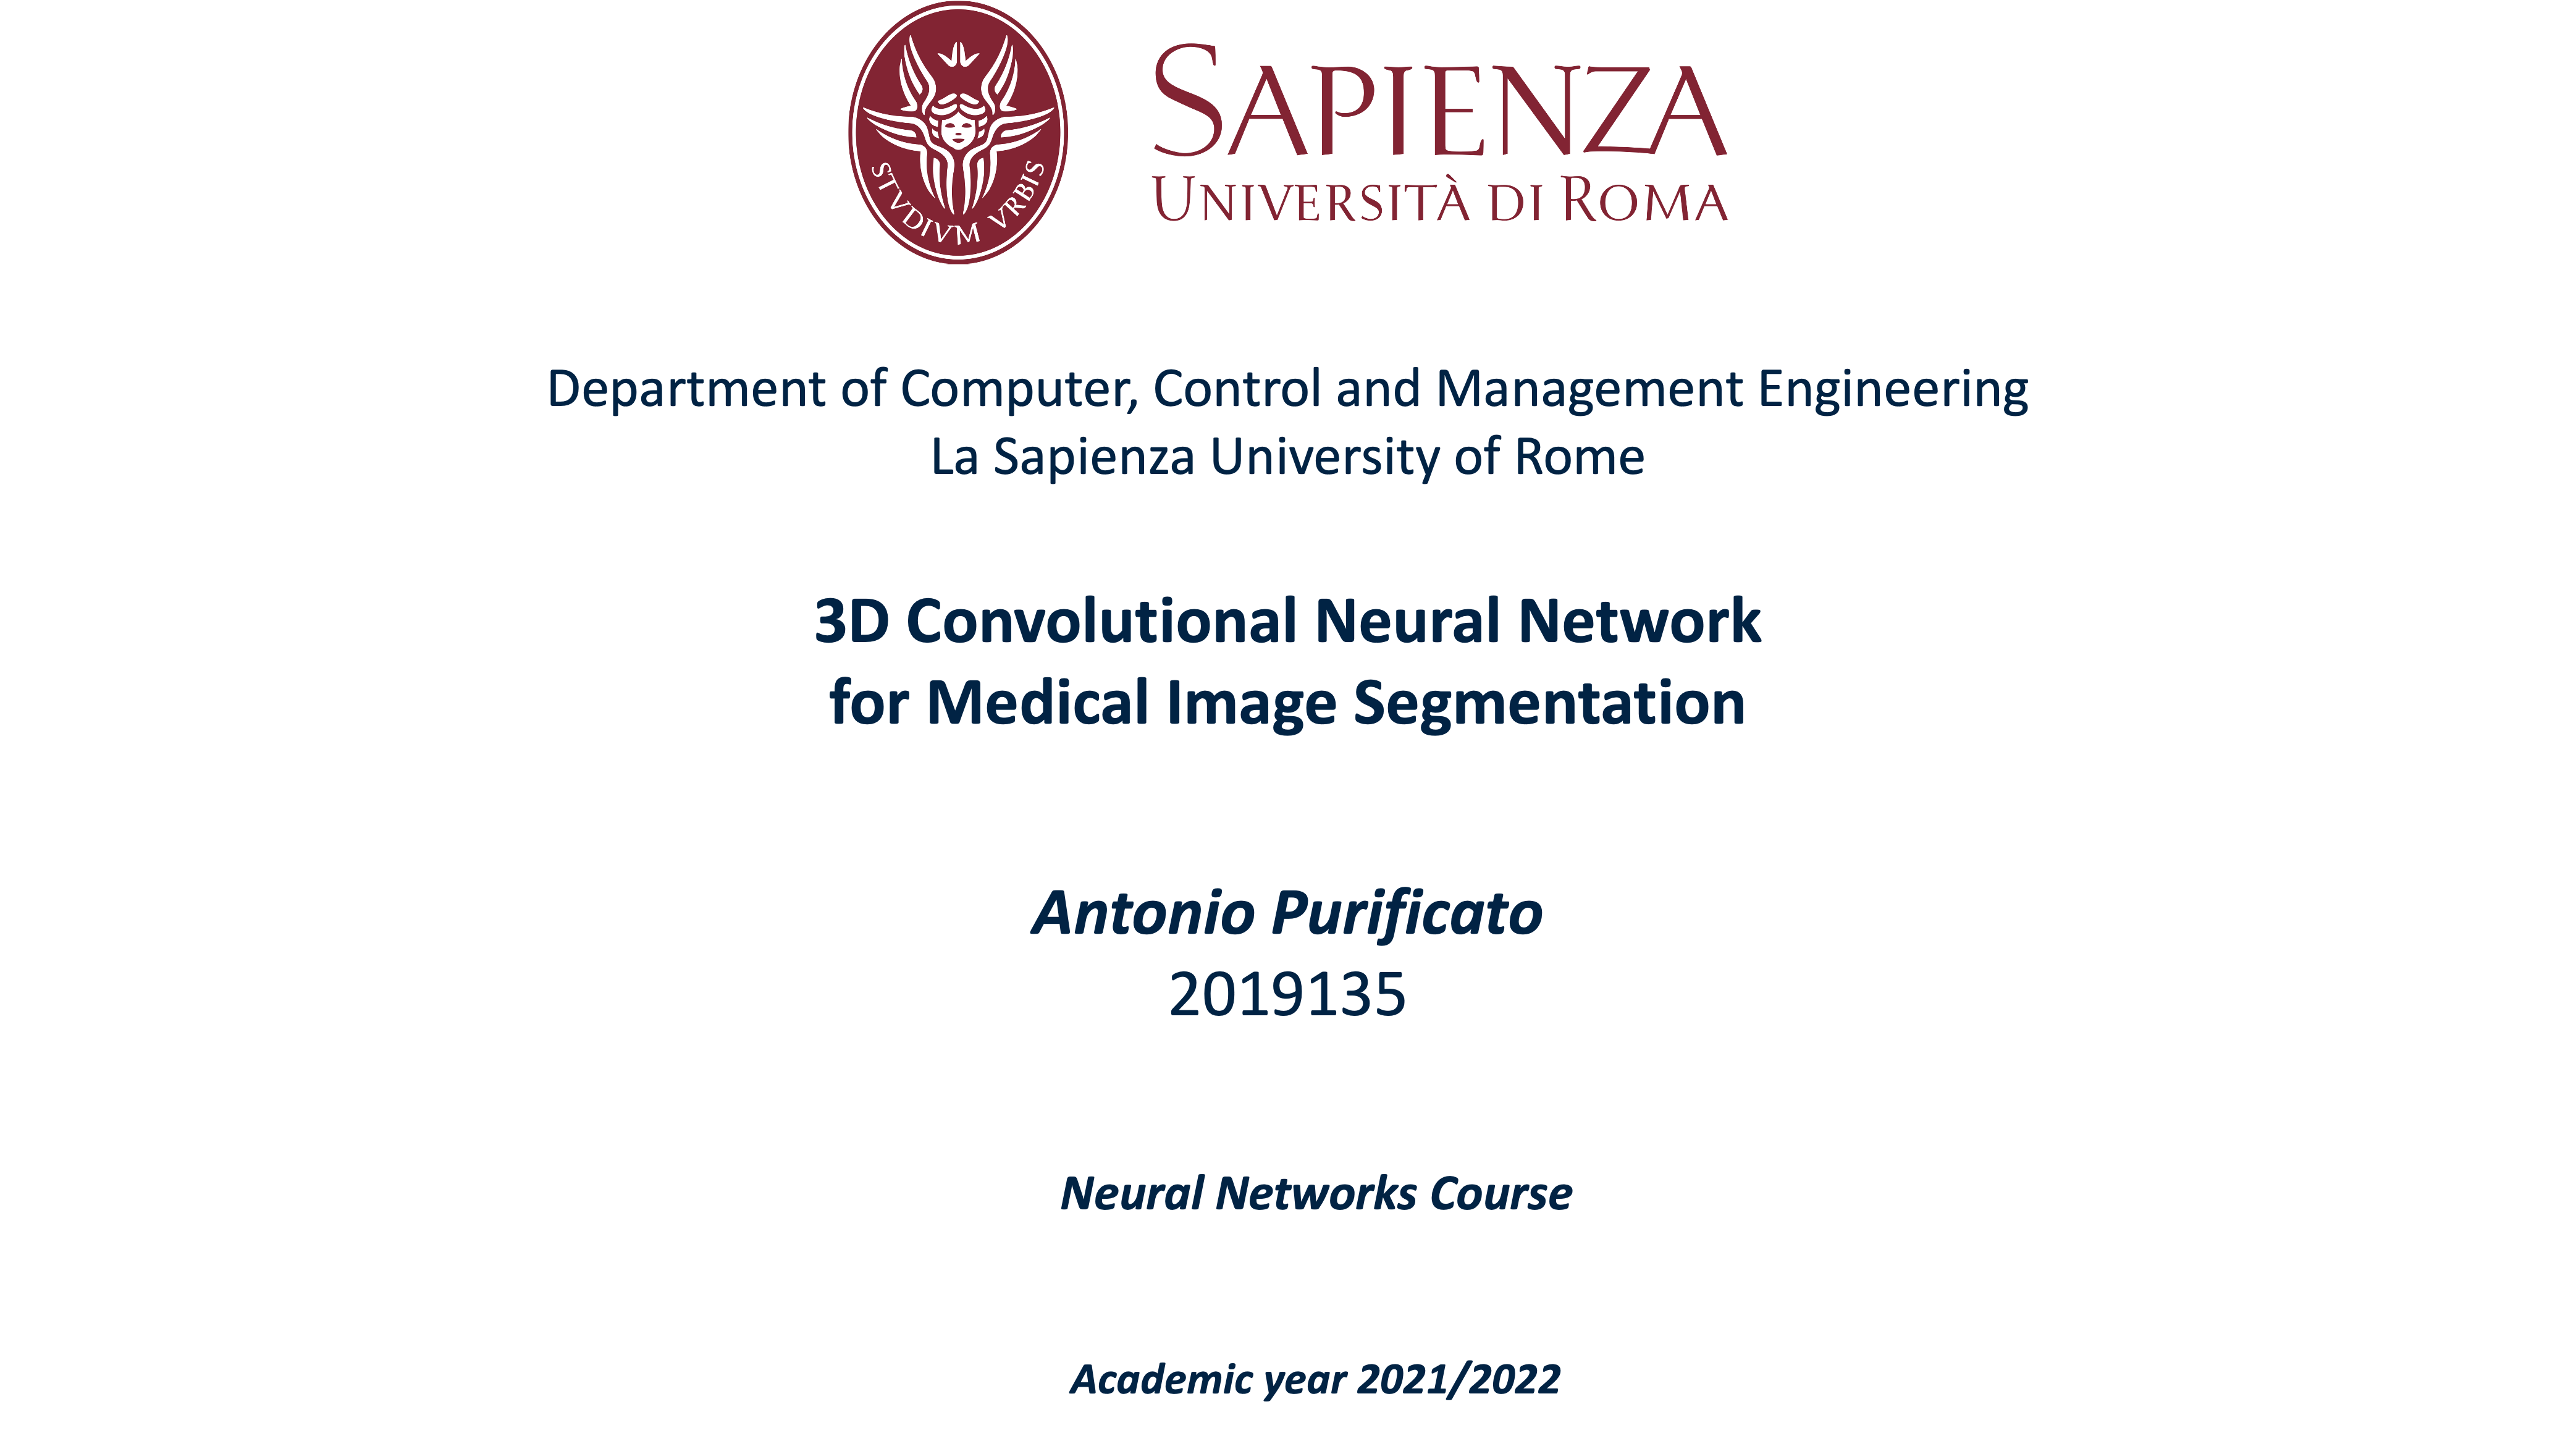

*The implementative choices of this architecture are described in the paper https://drive.google.com/file/d/1-E_rt2eUv7Uvdf-8gs7SZY4PtEN8nMQ6/view?usp=sharing*

<a href="https://colab.research.google.com/drive/1GXIZyI6MmW3nmephy5DrzXcSqAPYf9AM?authuser=1#scrollTo=nc5J0485Y7Dv" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

#Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive
!mkdir NN
%cd NN
! wget https://scholar.cu.edu.eg/Dataset_BUSI.zip
! unzip Dataset_BUSI.zip

In [ ]:
dataset_folder = '/content/drive/MyDrive/NN/Dataset_BUSI_with_GT/'
show_num = 2
training_epochs = 30

Import necessary libraries

In [ ]:
import os
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt


from sklearn import model_selection, metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization

import keras
from keras import models
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Activation, Lambda, Conv2D
from keras.layers import MaxPooling2D, UpSampling2D,Input, Concatenate, Conv2DTranspose
import keras.backend as K

##Load and Preprocess Data 
Using this method are parsed all the images in the folder containing the dataset stored in Google Drive.

In [ ]:
def parse_images(root_dir, size=(128, 128)):
  root_dir = [os.path.join(root_dir, path) for path in os.listdir(root_dir)]
  data = []
  masks = []

  for i in range(len(root_dir) // 2):
    path = [path for path in root_dir if (f'({i+1})' in path)]
    if len(path) == 2:
      path1, path2 = path
      if 'mask' in path1:
        mask_path = path1
        img_path = path2
      else:
        mask_path = path2
        img_path = path1
      
      #Images are converted to RGB and are splitted between images and masks
      img = cv2.imread(img_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      img = cv2.resize(img, size) / 255.
      mask = cv2.imread(mask_path)
      mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
      mask = cv2.resize(mask, size) / 255.
      data.append(img)
      masks.append(mask)

  return data, masks


The 80% of the images is used for training and the 20% for validation

In [ ]:
benign_imgs, benign_masks =  parse_images(dataset_folder + 'benign')
malignant_imgs, malignant_masks = parse_images(dataset_folder + 'malignant')
normal_imgs,  normal_masks = parse_images(dataset_folder + 'normal')


benign_imgs_train, benign_imgs_test, benign_masks_train, benign_masks_test = train_test_split(benign_imgs, benign_masks,
                                                                                              test_size=0.2,
                                                                                              shuffle=True, random_state=42)
malignant_imgs_train, malignant_imgs_test, malignant_masks_train, malignant_masks_test = train_test_split(malignant_imgs, malignant_masks,
                                                                                                          test_size=0.2,
                                                                                                          shuffle=True, random_state=42)
normal_imgs_train, normal_imgs_test, normal_masks_train, normal_masks_test = train_test_split(normal_imgs, normal_masks,
                                                                                              test_size=0.2,
                                                                                              shuffle=True, random_state=42)


X_train = np.concatenate((benign_imgs_train, malignant_imgs_train, normal_imgs_train))
Y_train = np.concatenate((benign_masks_train, malignant_masks_train, normal_masks_train))

X_test = np.concatenate((benign_imgs_test, malignant_imgs_test, normal_imgs_test))
Y_test = np.concatenate((benign_masks_test, malignant_masks_test, normal_masks_test))

##Visualization of the images

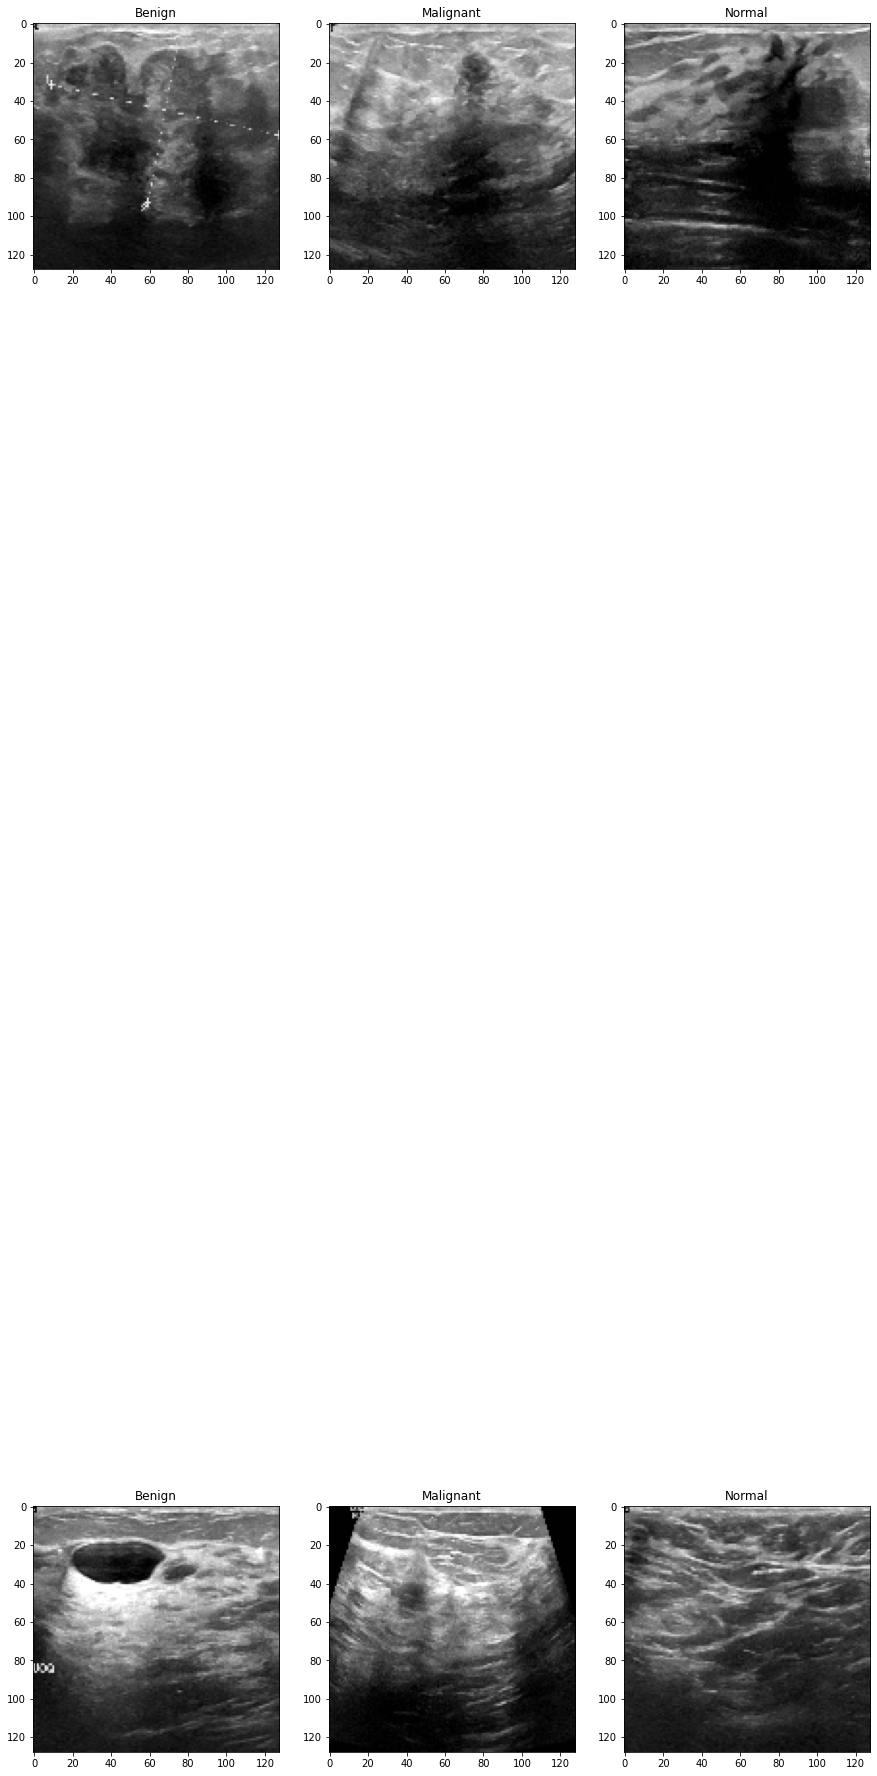

In [ ]:
fig, ax = plt.subplots(show_num, 3, figsize=(15, 50))

for i, pred in enumerate(benign_imgs_train[:show_num]):
    ax[i, 0].imshow(benign_imgs_train[i], cmap='gray')
    ax[i, 0].set_title('Benign')
    ax[i, 1].imshow(malignant_imgs_train[i], cmap='gray')
    ax[i, 1].set_title('Malignant')
    ax[i, 2].imshow(normal_imgs_train[i], cmap='gray')
    ax[i, 2].set_title('Normal')

##Visualization of the masks

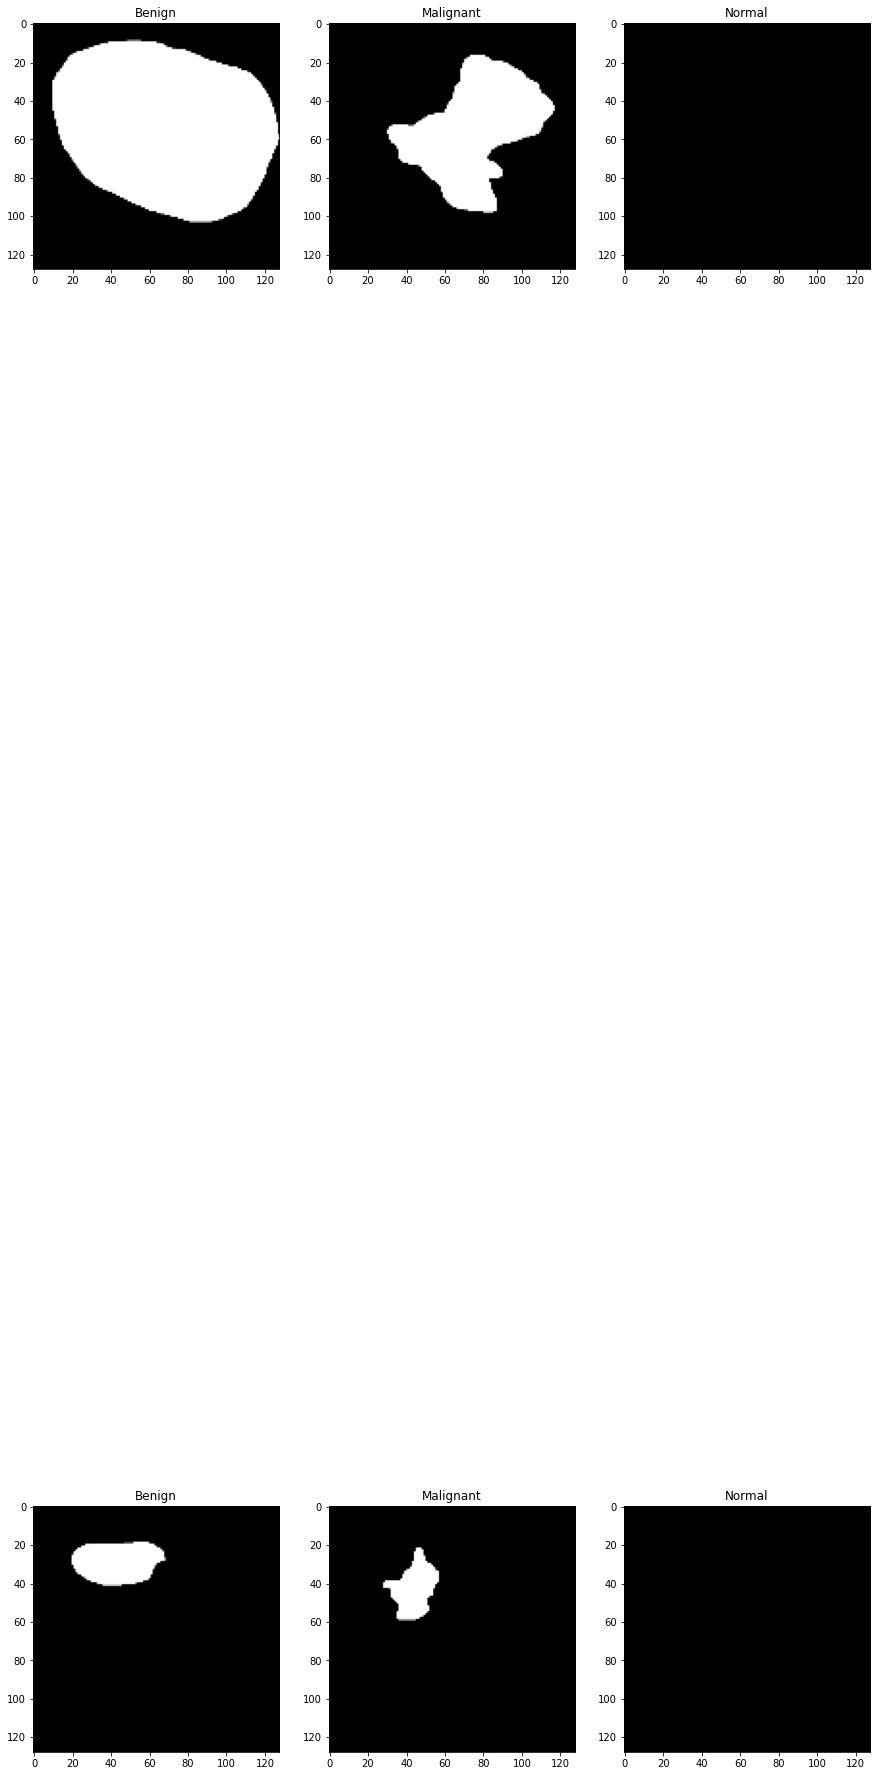

In [ ]:
fig, ax = plt.subplots(show_num, 3, figsize=(15, 50))

for i, pred in enumerate(benign_masks_train[:show_num]):
    ax[i, 0].imshow(benign_masks_train[i], cmap='gray')
    ax[i, 0].set_title('Benign')
    ax[i, 1].imshow(malignant_masks_train[i], cmap='gray')
    ax[i, 1].set_title('Malignant')
    ax[i, 2].imshow(normal_masks_train[i], cmap='gray')
    ax[i, 2].set_title('Normal')

#Data processing

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(609, 128, 128)
(609, 128, 128)
(154, 128, 128)
(154, 128, 128)


##Data standardization

In [ ]:
def data_std(X_train, X_test):
    mean = np.mean(X_train, axis=(0, 1, 2, 3))
    std = np.std(X_train, axis=(0, 1, 2, 3))

    X_train = (X_train - mean)/(std + 1e-7)
    X_test = (X_test - mean)/(std + 1e-7)

    return X_train, X_test

#Plot functions

##Dice score

In [ ]:
# plot history for accuracy
def plot_dice(history, title = None):
    fig = plt.figure()
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['dice_coef'])
    plt.plot(history['val_dice_coef'])
    if title is not None:
        plt.title(title)

    plt.ylabel('Dice_coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc=0)

##Loss

In [ ]:
def plot_loss(history, title = None):
    fig = plt.figure()
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    if title is not None:
        plt.title(title)

    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.legend(['Train', 'Val'], loc=0)

#U-Net Model

In [ ]:
class UNet(object):
    def __init__(self, img_shape, num_of_class, activation = 'relu',
        learning_rate = 0.001,  drop_rate = 0.5, do_batch_norm = False, do_drop = False):

        '''
        Arguments :

        img_shape - shape of input image (64, 64, 1)
        activation - activation function for network training
        learning_rate - learning rate for training
        drop_rate - dropout rate
        do_batch_norm - whether to run for batchnormalization
        do_drop - whether to run for dropout
        '''

        self.learning_rate = learning_rate
        self.activation = activation
        self.img_shape = img_shape
        self.num_of_class = num_of_class
        self.drop_rate = drop_rate
        self.do_batch_norm = do_batch_norm
        self.do_drop = do_drop

        self.model = self.build_model()


    # encoding block(conv - conv - pool)
    def enc_conv_block(self, inputs, feature_maps, filter_size = (3, 3),
                           conv_strides = 1, pooling_filter_size = (2, 2), pooling_strides = (2, 2)):
        conv1 = Conv2D(feature_maps , filter_size , activation = self.activation, strides = conv_strides,
                           padding = 'same', kernel_initializer = 'he_normal')(inputs)
        conv2 = Conv2D(feature_maps , filter_size , activation = self.activation, strides = conv_strides,
                           padding = 'same', kernel_initializer = 'he_normal')(conv1)
        pool = MaxPooling2D(pooling_filter_size, strides = pooling_strides)(conv2)

        return pool, conv2


    # decoding block(concat - upconv - upconv)
    def dec_conv_block(self, inputs, merge_inputs, feature_maps, filter_size = (3, 3), conv_strides = 1,
                           up_conv_strides = (2, 2)):

        merge = Concatenate(axis = 3)([Conv2DTranspose(feature_maps, filter_size,
                                                       activation = self.activation, strides = up_conv_strides, kernel_initializer = 'he_normal',
                                                       padding = 'same')(inputs), merge_inputs])

        conv1 = Conv2D(feature_maps , filter_size , activation = self.activation, strides = conv_strides,
                           padding = 'same', kernel_initializer = 'he_normal')(merge)
        conv2 = Conv2D(feature_maps , filter_size , activation = self.activation, strides = conv_strides,
                           padding = 'same', kernel_initializer = 'he_normal')(conv1)

        return conv2

    # Encoder
    def encoding_path(self, inputs):

        enc_conv1, concat1 = self.enc_conv_block(inputs, 64)
        enc_conv2, concat2 = self.enc_conv_block(enc_conv1, 128)
        enc_conv3, concat3 = self.enc_conv_block(enc_conv2, 256)
        enc_conv4, concat4 = self.enc_conv_block(enc_conv3, 512)

        return concat1, concat2, concat3, concat4, enc_conv4

    # Decoder
    def decoding_path(self, dec_inputs, concat1, concat2, concat3, concat4):

        dec_conv1 = self.dec_conv_block(dec_inputs, concat4, 512)
        dec_conv2 = self.dec_conv_block(dec_conv1, concat3, 256)
        dec_conv3 = self.dec_conv_block(dec_conv2, concat2, 128)
        dec_conv4 = self.dec_conv_block(dec_conv3, concat1, 64)

        return dec_conv4
        
    # build network
    def build_model(self):
        inputs = Input(self.img_shape)

        # Contracting path
        concat1, concat2, concat3, concat4, enc_path = self.encoding_path(inputs)

        # middle path
        mid_path1 = Conv2D(1024, (3,3), activation = self.activation, padding = 'same', kernel_initializer = 'he_normal')(enc_path)
        mid_path1 = Dropout(self.drop_rate)(mid_path1)
        mid_path2 = Conv2D(1024, (3,3), activation = self.activation, padding = 'same', kernel_initializer = 'he_normal')(mid_path1)
        mid_path2 = Dropout(self.drop_rate)(mid_path2)

        # Expanding path where is performed the upsampling
        dec_path = self.decoding_path(mid_path2, concat1, concat2, concat3, concat4)
        segmented = Conv2D(self.num_of_class, (1,1), activation ='sigmoid', padding = 'same', kernel_initializer = 'glorot_normal')(dec_path)

        model = Model(inputs = inputs, outputs = segmented)
        model.compile(optimizer = Adam(lr = self.learning_rate),
                          loss = 'binary_crossentropy', metrics = [dice_coef])

        return model


    def train(self, X_train, Y_train, epoch = 10, batch_size = 32, val_split = 0.2, shuffle = True):

        self.history = self.model.fit(X_train, Y_train, validation_split = val_split,
                                          epochs = epoch, batch_size = batch_size, shuffle =  shuffle)
        return self.history


    def predict(self, X_test):
        pred_classes = self.model.predict(X_test)

        return pred_classes

    # Show the model
    def show_model(self):
        return print(self.model.summary())

#Loss function

In [ ]:
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return 1- (2. * intersection + K.epsilon()) / (K.sum(y_true) + K.sum(y_pred) + K.epsilon())

#Build the model

In [ ]:
seg_model = UNet(img_shape = (128,128,1),num_of_class = 1, do_drop = True, drop_rate = 0.7,learning_rate = 5e-4)
model = seg_model.model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


##Training

In [ ]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Cancer.h5',
    save_weights_only=True,
    monitor='val_dice_coef',
    mode='max',
    save_best_only=True)
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = training_epochs, callbacks=[callback])

Epoch 1/30
20/20 [==============================] - 21s 950ms/step - loss: 0.3628 - dice_coef: 0.8862 - val_loss: 0.3275 - val_dice_coef: 0.8456
Epoch 2/30
20/20 [==============================] - 18s 919ms/step - loss: 0.3007 - dice_coef: 0.8868 - val_loss: 0.3005 - val_dice_coef: 0.9145
Epoch 3/30
20/20 [==============================] - 18s 897ms/step - loss: 0.2744 - dice_coef: 0.9036 - val_loss: 0.2729 - val_dice_coef: 0.9067
Epoch 4/30
20/20 [==============================] - 18s 897ms/step - loss: 0.2655 - dice_coef: 0.8838 - val_loss: 0.2652 - val_dice_coef: 0.8581
Epoch 5/30
20/20 [==============================] - 18s 897ms/step - loss: 0.2459 - dice_coef: 0.8475 - val_loss: 0.2275 - val_dice_coef: 0.8301
Epoch 6/30
20/20 [==============================] - 18s 900ms/step - loss: 0.1982 - dice_coef: 0.7216 - val_loss: 0.3062 - val_dice_coef: 0.6818
Epoch 7/30
20/20 [==============================] - 18s 896ms/step - loss: 0.2253 - dice_coef: 0.8178 - val_loss: 0.2117 - val_dic

##Prediction

In [ ]:
preds = model.predict(X_test)

#Results

##Dice loss

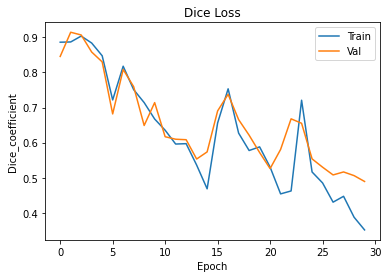

In [ ]:
plot_dice(history,title = 'Dice Loss')

##Loss

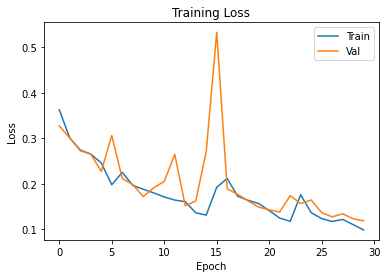

In [ ]:
plot_loss(history,title = 'Training Loss')

##Images

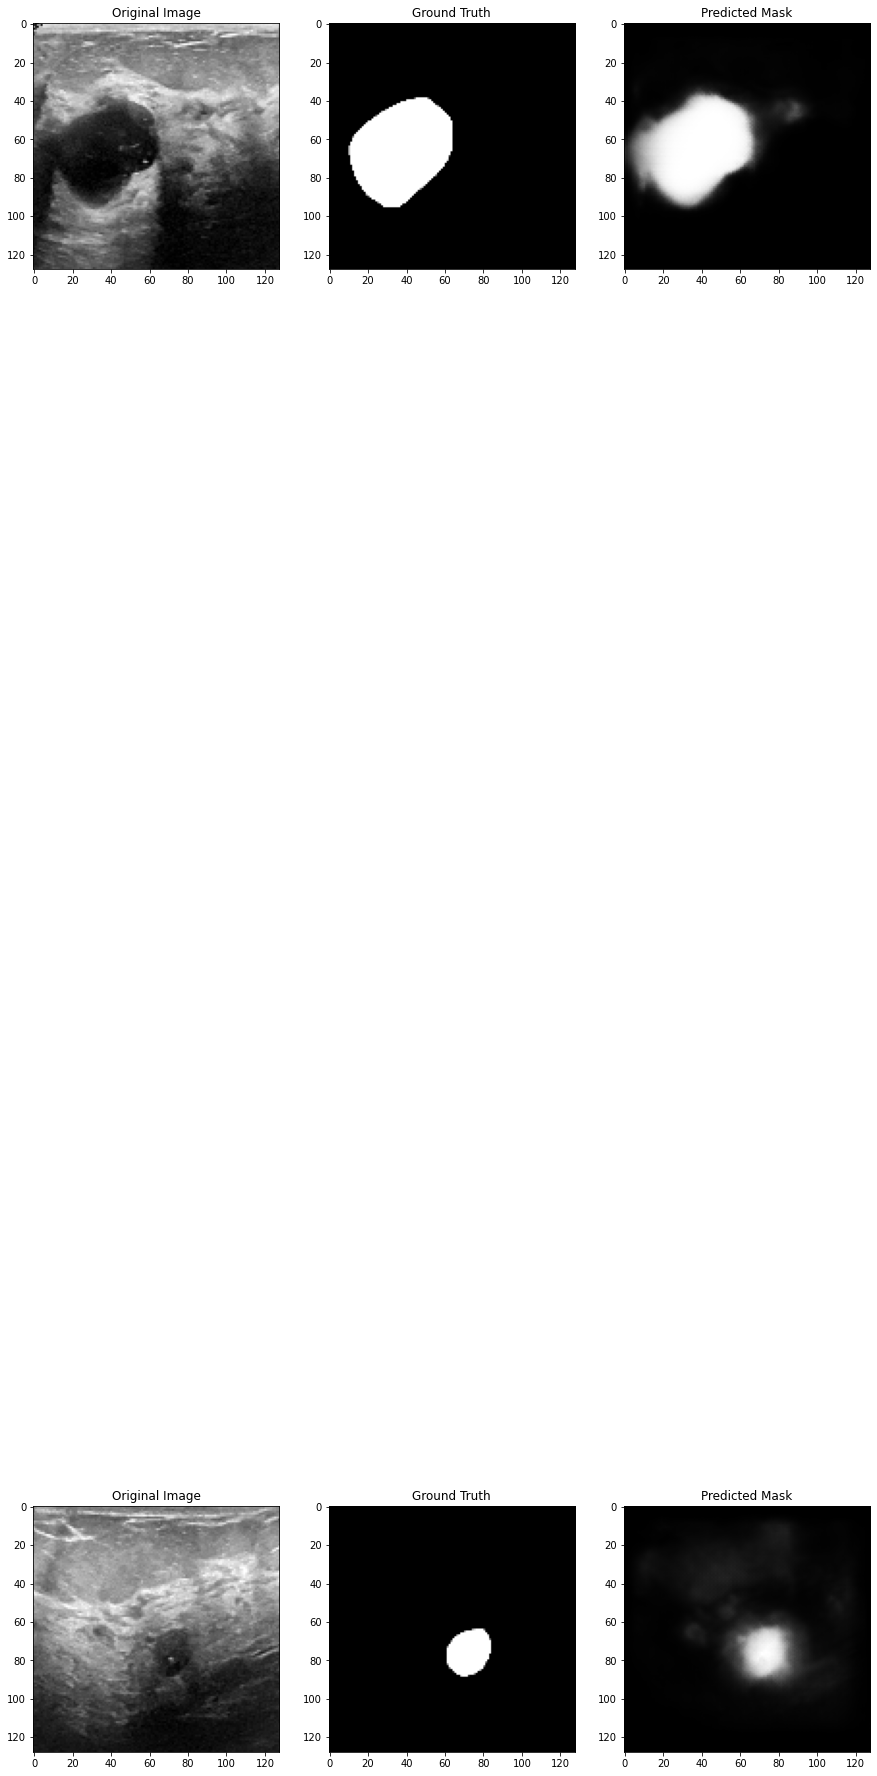

In [ ]:
fig, ax = plt.subplots(show_num, 3, figsize=(15, 50))

for i, pred in enumerate(preds[:show_num]):
    ax[i, 0].imshow(X_test[i].squeeze(), cmap='gray')
    ax[i, 0].set_title('Original Image')
    ax[i, 1].imshow(Y_test[i].squeeze(), cmap='gray')
    ax[i, 1].set_title('Ground Truth')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')
    ax[i, 2].set_title('Predicted Mask')
